# MNIST Dataset

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [4]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)

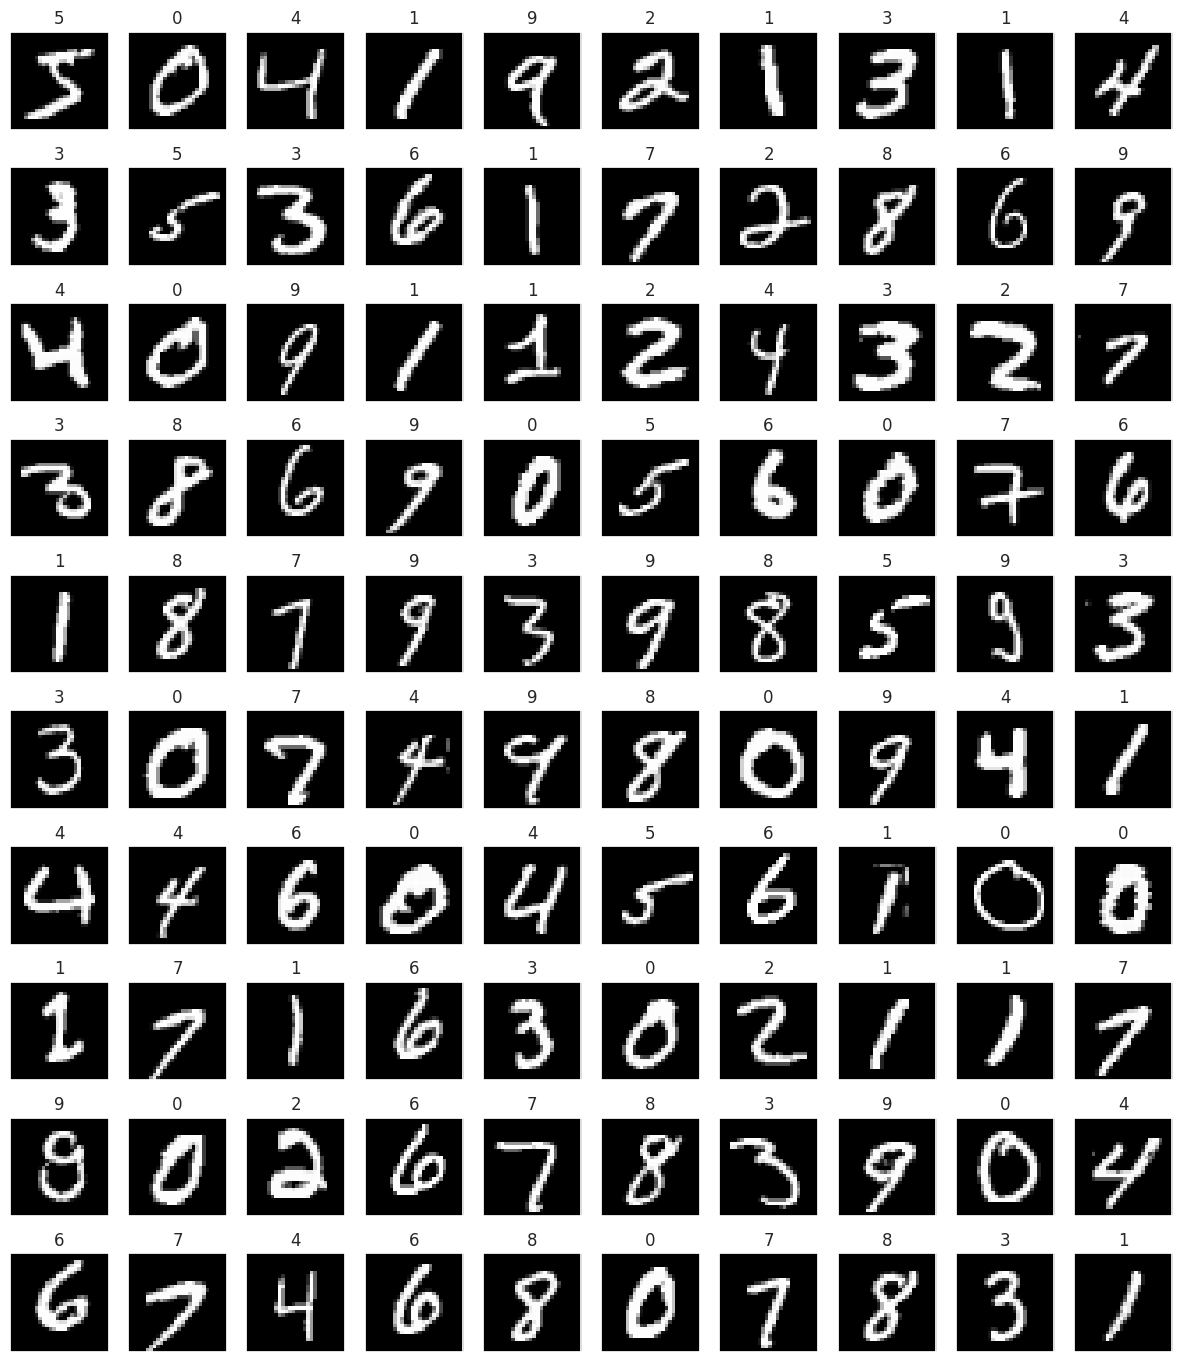

In [5]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))

cnt = 0
for a in ax.flatten():
    a.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    a.imshow(x_train[cnt], cmap='gray')
    a.set_title(y_train[cnt])
    cnt += 1
    a.grid(False)
fig.subplots_adjust(top=1)

In [6]:
print(f'Number of Training images {x_train.shape[0]}')
print(f'Number of Validation images {x_val.shape[0]}')
print(f'Number of test images {x_test.shape[0]}')

print(f'Image shape is {x_train.shape[1:]}')
image_shape = x_train.shape[1:]

Number of Training images 60000
Number of Validation images 5000
Number of test images 5000
Image shape is (28, 28, 1)


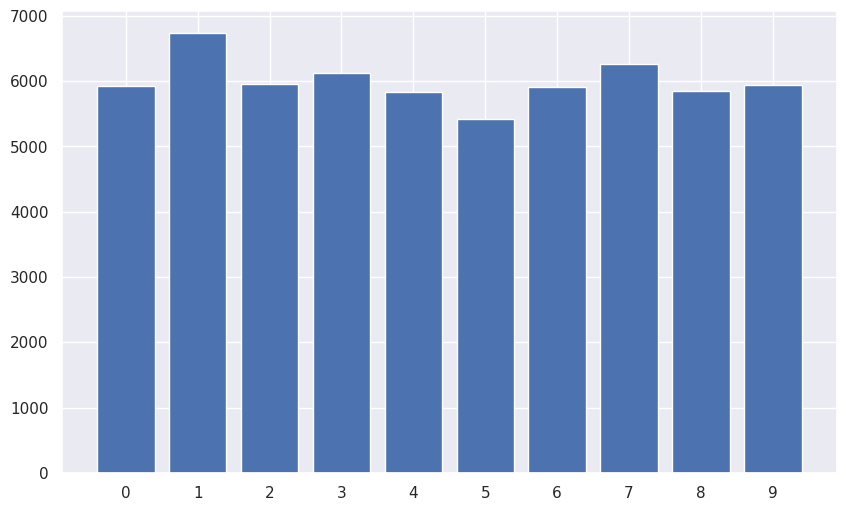

In [7]:
numbers = [0 for _ in range(10)]
for num in y_train:
    numbers[num] += 1
    
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.bar(range(0, 10), numbers);
ax = plt.gca()
ax.set_xticks([x for x in range(10)]);

## Creating model

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(rescale=1./255)

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Activation, Flatten, Dense

In [10]:
def get_uncompiled_model(image_shape):
    inputs = Input(shape=image_shape)
    X = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(inputs)
    X = Activation('relu')(X)
    X = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(X)
    X = Activation('relu')(X)
    X = BatchNormalization(axis=-1)(X, training=True)
    X = MaxPooling2D(strides=2)(X)
    
    X = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(X)
    X = Activation('relu')(X)
    X = BatchNormalization(axis=-1)(X, training=True)
    X = MaxPooling2D(strides=2)(X)
    
    X = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(X)
    X = Activation('relu')(X)
    X = BatchNormalization(axis=-1)(X, training=True)
    X = MaxPooling2D(strides=2)(X)
    
    X = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(X)
    X = Activation('relu')(X)
    X = BatchNormalization(axis=-1)(X, training=True)
    
    X = Flatten()(X)
    X = Dense(units=128, activation='relu')(X)
    X = Dropout(0.2)(X)
    outputs = Dense(units=10, activation='softmax')(X)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
model = get_uncompiled_model(image_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 activation (Activation)     (None, 28, 28, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 activation_1 (Activation)   (None, 28, 28, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                             

In [12]:
def incorrect_prediction(y_true, y_pred):
    return tf.reduce_sum(tf.cast(tf.not_equal(y_pred, y_true), 'int64'))

In [13]:
class F1_Score(tf.keras.metrics.Metric):
    '''
    True Positive (TP): The number of instances that were correctly classified as positive.
    False Positive (FP): The number of instances that were incorrectly classified as positive.
    True Negative (TN): The number of instances that were correctly classified as negative.
    False Negative (FN): The number of instances that were incorrectly classified as negative.
    
    Precision is the fraction of positive instances that were correctly classified. It is calculated as follows:
    Precision = TP / (TP + FP)
    
    Recall is the fraction of all positive instances that were correctly classified. It is calculated as follows:
    Recall = TP / (TP + FN)
    
    The F1 score is a measure of a model's accuracy that takes into account both the precision and recall of the model. It is calculated as follows:
    F1 = 2 * (precision * recall) / (precision + recall)
    
    where:
    Precision is the fraction of positive instances that were correctly classified.
    Recall is the fraction of all positive instances that were correctly classified.
    '''
    def __init__(self, name='f1_score', **kwargs):
        super(F1_Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
            
    def result(self):
        self.f1.assign(2 * (self.precision.result() * self.recall.result()) / (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))
        return self.f1
    
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [14]:
loss = tf.losses.SparseCategoricalCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', F1_Score()])

In [15]:
with tf.device('GPU:0'):
    training_gen = data_generator.flow(x_train, y_train, batch_size=64)
    validation_gen = data_generator.flow(x_val, y_val, batch_size=64)
    history = model.fit(training_gen, validation_data=validation_gen, epochs=10)

Epoch 1/10
938/938 [==============================] - 41s 36ms/step - loss: 0.1130 - accuracy: 0.9651 - f1_score: 0.9977 - val_loss: 0.0451 - val_accuracy: 0.9844 - val_f1_score: 0.9988
Epoch 2/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0446 - accuracy: 0.9871 - f1_score: 0.9992 - val_loss: 0.0270 - val_accuracy: 0.9912 - val_f1_score: 0.9992
Epoch 3/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0333 - accuracy: 0.9903 - f1_score: 0.9993 - val_loss: 0.0359 - val_accuracy: 0.9908 - val_f1_score: 0.9996
Epoch 4/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0262 - accuracy: 0.9922 - f1_score: 0.9995 - val_loss: 0.0246 - val_accuracy: 0.9926 - val_f1_score: 0.9992
Epoch 5/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0238 - accuracy: 0.9926 - f1_score: 0.9996 - val_loss: 0.0328 - val_accuracy: 0.9906 - val_f1_score: 0.9994
Epoch 6/10
938/938 [==============================] - 33s 35ms/step - 

## Model Evaluation

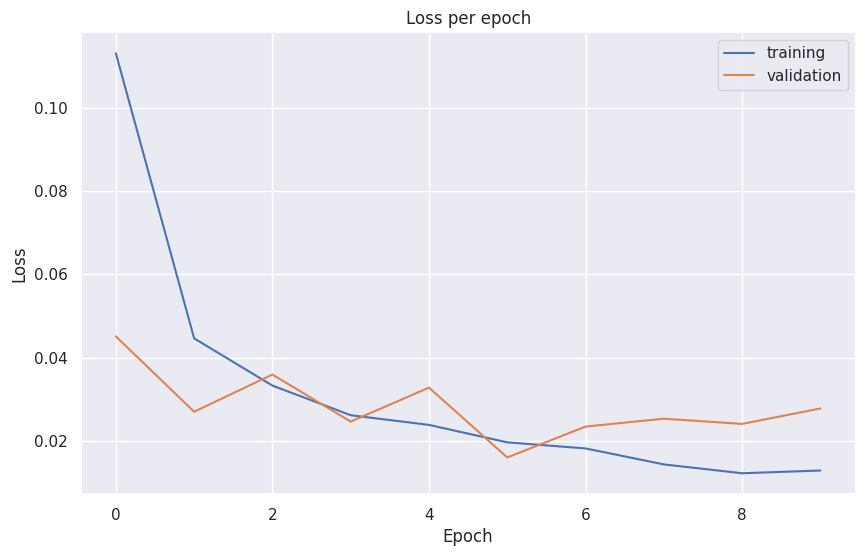

In [16]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.epoch, history.history['loss'], label='training')
plt.plot(history.epoch, history.history['val_loss'], label='validation')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss');
plt.legend();

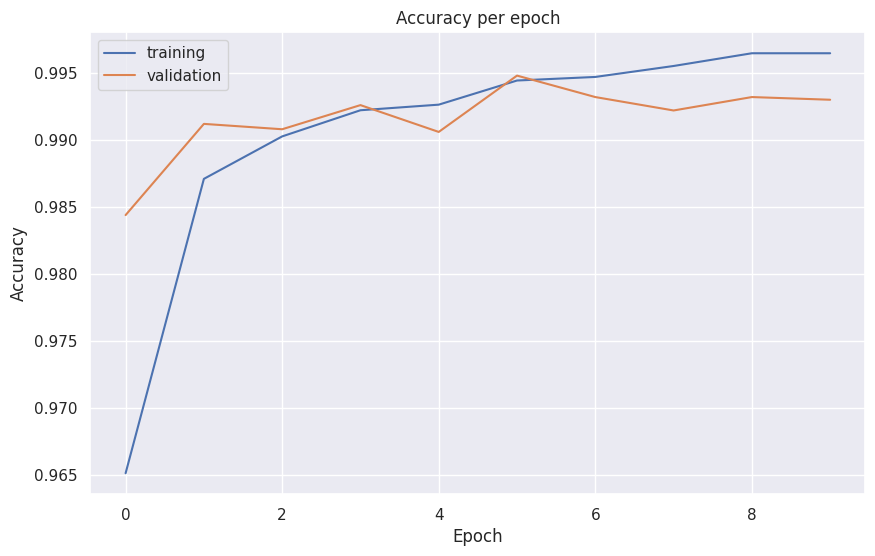

In [17]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.epoch, history.history['accuracy'], label='training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')
plt.title('Accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');
plt.legend();

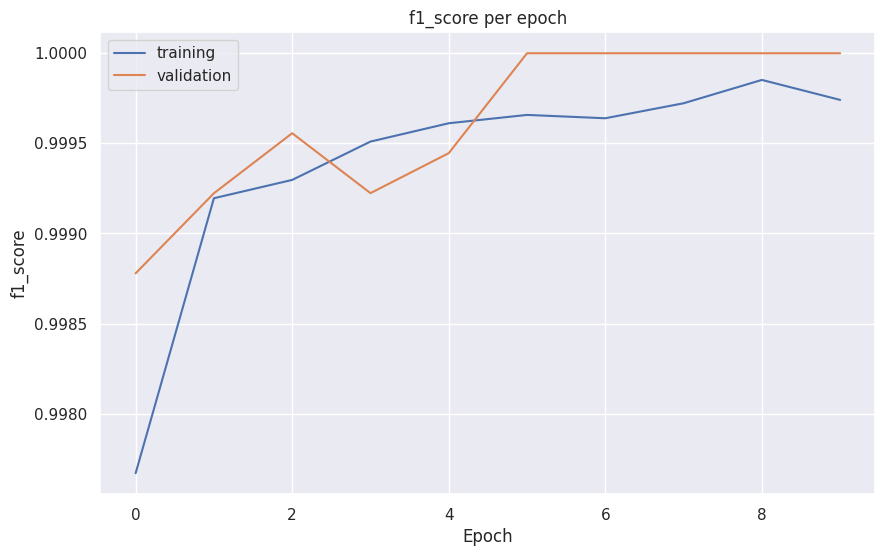

In [18]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.epoch, history.history['f1_score'], label='training')
plt.plot(history.epoch, history.history['val_f1_score'], label='validation')
plt.title('f1_score per epoch')
plt.xlabel('Epoch')
plt.ylabel('f1_score');
plt.legend();

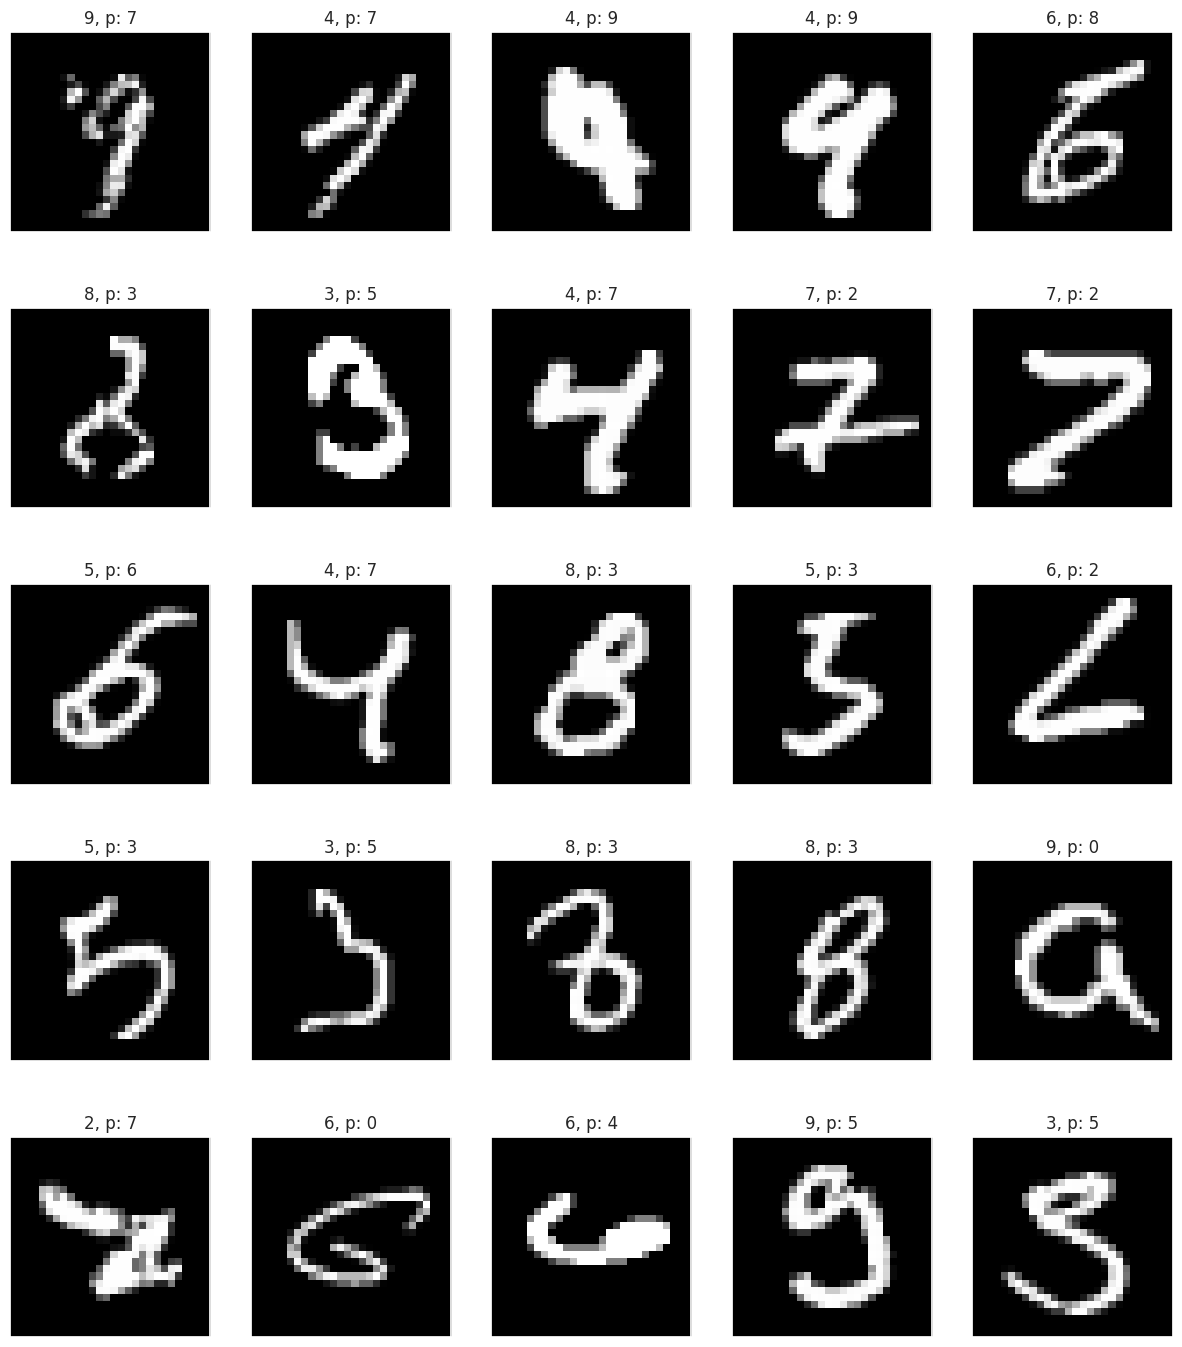

In [19]:
y_hat = tf.cast(tf.argmax(model.predict(x_val, verbose=0), axis=-1), 'int64')
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
ax = ax.flatten()

i = 0
cnt = 0
while cnt < len(ax):
    if y_hat[i] == y_val[i]: 
        i += 1
        continue
    ax[cnt].tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    ax[cnt].imshow(x_val[i], cmap='gray')
    ax[cnt].set_title(f'{y_val[i]}, p: {y_hat[i]}')
    ax[cnt].grid(False)
    i += 1
    cnt += 1
fig.subplots_adjust(top=1)

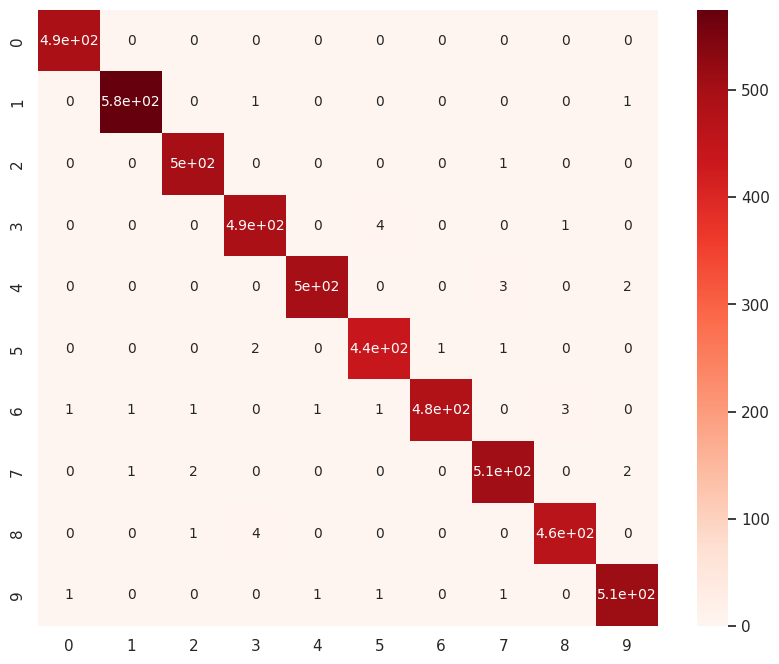

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = tf.argmax(model.predict(x_val, verbose=0), axis=-1)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, xticklabels=[x for x in range(10)], yticklabels=[x for x in range(10)],
                annot_kws={"size": 10}, cmap='Reds')

In [21]:
y_pred = tf.argmax(model.predict(x_val, verbose=0), axis=-1)
print(f"There are {incorrect_prediction(y_val, y_pred)} incorrect predictions in validation")
y_pred = tf.argmax(model.predict(x_test, verbose=0), axis=-1)
print(f"There are {incorrect_prediction(y_test, y_pred)} incorrect predictions in test")

There are 39 incorrect predictions in validation
There are 36 incorrect predictions in test


In [22]:
y_pred = tf.argmax(model.predict(x_test, verbose=0), axis=-1)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       488
           1       0.99      0.99      0.99       558
           2       0.99      1.00      1.00       532
           3       0.99      1.00      1.00       511
           4       0.99      0.99      0.99       477
           5       1.00      0.99      0.99       450
           6       1.00      0.98      0.99       470
           7       0.99      0.99      0.99       517
           8       1.00      1.00      1.00       504
           9       0.99      0.99      0.99       493

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

